In [108]:
import os
import numpy as np
import numpy.ma as ma
from astropy.table import Table
from scipy.optimize import minimize, Bounds
from DRP_rotation_curve import extract_data, extract_Pipe3d_data
from disk_mass import calc_mass_curve, fit_mass_curve
from rotation_fitfunctions import find_phi, parameterfit_iso, parameterfit_NFW, parameterfit_bur, rot_incl_iso, rot_incl_bur, \
rot_incl_NFW
from rotation_curve_functions import disk_bulge_vel
import RC_plotting_functions as RC#import plot_diagnostic_panel
import matplotlib.pyplot as plt
%matplotlib inline

In [107]:
import importlib
import rotation_fitfunctions
import rotation_curve_functions
importlib.reload(RC_plotting_functions)
importlib.reload(rotation_fitfunctions)
importlib.reload(rotation_curve_functions)

<module 'rotation_curve_functions' from 'C:\\Users\\Lara\\Documents\\rotationcurves\\rotation_curve_functions.py'>

In [2]:
gal_ID = '7443-12705'
H_0 = 100  # Hubble's Constant in units of h km/s/Mpc
c = 299792.458  # Speed of light in units of km/s
fit_function = 'bulge'


In [3]:
MASS_MAP_FOLDER = r"C:\Users\Lara\Documents\rotationcurves\mangadata\pipe3d\v3_1_1\3.1.1\7443"
VEL_MAP_FOLDER = r"C:\Users\Lara\Documents\rotationcurves\mangadata\analysis\v3_1_1\3.1.0\HYB10-MILESHC-MASTARSSP\7443\12705"
DRP_FILENAME = r"C:\Users\Lara\Documents\rotationcurves\mangadata\redux\v3_1_1\drpall-v3_1_1.fits"

In [4]:
DRP_FILENAME = r"C:\Users\Lara\Documents\rotationcurves\mangadata\redux\v3_1_1\drpall-v3_1_1.fits"
DRP_table = Table.read( DRP_FILENAME, format='fits')


DRP_index = {}

for i in range(len(DRP_table)):
    galaxy_ID = DRP_table['plateifu'][i]

    DRP_index[galaxy_ID] = i


In [5]:
maps = extract_data(VEL_MAP_FOLDER,gal_ID,['Ha_vel', 'r_band', 'Ha_flux', 'Ha_sigma'])
sMass_density, sMass_density_err = extract_Pipe3d_data(MASS_MAP_FOLDER, gal_ID)
i_DRP = DRP_index[gal_ID]
axis_ratio = DRP_table['nsa_sersic_ba'][i_DRP]
incl = np.arccos(np.sqrt((axis_ratio**2 - 0.2**2)/1-0.2**2)) 
phi = DRP_table['nsa_elpetro_phi'][i_DRP]
print(incl)
print(phi)
z = DRP_table['nsa_z'][i_DRP]
map_mask = maps['Ha_vel_mask']

maps['vmasked'] = ma.array(maps['Ha_vel'], mask=map_mask)
maps['ivarmasked'] = ma.array(maps['Ha_vel_ivar'], mask=map_mask)

shape = maps['vmasked'].shape
scale = (0.5 * z * c / H_0) * 1000 / 206265  # kpc
center = np.unravel_index(ma.argmax(maps['r_band']), shape)
x_center = center[0]
y_center = center[1]
count = 0
phi = find_phi(center, phi, maps['vmasked'])
param = [incl, phi, x_center, y_center]

1.3432236922176852
36.9388
-9.503156
(37, 37)
0.6447036817356814


finding mass curve
7443-12705 mass curve calculated


C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:387: RuntimeWarning: invalid value encountered in multiply
  bessel_component = (iv(0, y) * kn(0, y) - iv(1, y) * kn(1, y))
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:396: RuntimeWarning: invalid value encountered in true_divide
  vb_2 = coeff_2 * F / r
C:\Users\Lara\Documents\rotationcurves\disk_mass_plotting_functions.py:89: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[fit_parameters['Sigma_disk'],
C:\Users\Lara\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


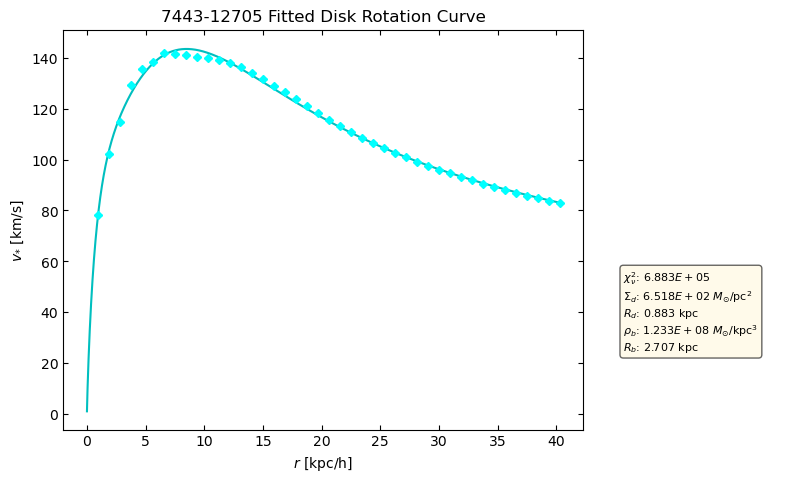

{'Sigma_disk': 651.7835239882832, 'Sigma_disk_err': 18.723074450561175, 'R_disk': 0.8827322508593658, 'R_disk_err': 0.03981341865250983, 'rho_bulge': 123265011.61568671, 'rho_bulge_err': 3965352.645964117, 'R_bulge': 2.7068887082844193, 'R_bulge_err': 0.02762104066321019, 'chi2_disk': 688338.7725421963}


In [6]:
mass_data_table = calc_mass_curve(sMass_density,
                                          sMass_density_err,
                                          maps['r_band'],
                                          map_mask,
                                          x_center,
                                          y_center,
                                          axis_ratio,
                                          phi,
                                          z,
                                          gal_ID)
print(gal_ID, "mass curve calculated")
param_outputs = fit_mass_curve(mass_data_table,
                                       gal_ID,
                                       fit_function)
print(param_outputs)


In [7]:
SigD = 651.7835239882832
Rd = 0.8827322508593658
rho_bulge = 123265011.61568671
R_bulge = 2.7068887082844193

In [9]:
best_fit_NFW = parameterfit_NFW(param, param_outputs['rho_bulge'], param_outputs['R_bulge'],
                                        param_outputs['Sigma_disk'], param_outputs['R_disk'], scale, shape,
                                        maps['vmasked'], maps['ivarmasked'], map_mask)


C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:229: RuntimeWarning: invalid value encountered in double_scalars
  vel = np.sqrt(coeff_2 * F / r)
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:347: RuntimeWarning: invalid value encountered in double_scalars
  bessel_component = (iv(0, y) * kn(0, y) - iv(1, y) * kn(1, y))
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:590: RuntimeWarning: invalid value encountered in double_scalars
  vel2 = G * (halo_mass * Msun) / (r * 3.08E16)
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:589: RuntimeWarning: invalid value encountered in log
  halo_mass = 4*np.pi*rho0_h*Rh**3*((-r/(Rh+r)) + np.log(Rh + r) - np.log(Rh))


---------------------------------------------------
   direc: array([[-2.29866416e-15,  2.54887176e-02,  0.00000000e+00,
         2.08522437e-02, -2.70651655e-01, -9.10222076e-01,
        -3.01957320e+00],
       [-4.51286618e-02,  7.32113495e-01,  2.51801464e-03,
        -7.65779764e-03, -2.08010017e-01, -2.19073734e-02,
         4.14018155e-01],
       [-4.91530334e-02,  9.56988796e-01,  2.49608167e-03,
         2.45718606e-03,  8.17948179e-02,  1.00265389e-01,
         2.45745864e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-8.99019239e-02,  1.44891914e-01,  0.00000000e+00,
        -3.32996471e-02, -1.18089163e+00, -2.56606800e-01,
         1.72016087e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [-4.69834209e-02,  9.12392745e-01,  3.40806851e-03,
         4.6706

In [10]:
best_fit_bur = parameterfit_bur(param, param_outputs['rho_bulge'], param_outputs['R_bulge'],
                                        param_outputs['Sigma_disk'], param_outputs['R_disk'], scale, shape,
                                        maps['vmasked'], maps['ivarmasked'], map_mask)

---------------------------------------------------
   direc: array([[ 2.96666689e-02, -2.62434542e-01, -8.62369224e-03,
         1.04721607e-03, -7.46861764e-02,  2.33384930e-02,
         5.89168860e-01],
       [ 4.27674207e-02, -8.96874676e-01, -1.22074429e-04,
        -2.51009623e-04, -9.84113835e-02,  2.07777155e-01,
         2.62440679e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 3.39708084e-03, -3.83379244e-02, -1.57281249e-04,
        -1.2041

In [11]:
best_fit_iso = parameterfit_iso(param, param_outputs['rho_bulge'], param_outputs['R_bulge'],
                                        param_outputs['Sigma_disk'], param_outputs['R_disk'], scale, shape,
                                        maps['vmasked'], maps['ivarmasked'], map_mask)

C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:505: RuntimeWarning: divide by zero encountered in double_scalars
  vel2 = v_inf2 * (1 - ((Rh/r)*np.arctan2(r,Rh)))
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:505: RuntimeWarning: invalid value encountered in double_scalars
  vel2 = v_inf2 * (1 - ((Rh/r)*np.arctan2(r,Rh)))


---------------------------------------------------
   direc: array([[-1.47798445e-01,  1.97242649e-01,  0.00000000e+00,
        -2.21128194e-02,  4.34466598e-01,  3.33793292e-01,
        -1.53616406e+00],
       [-3.02701838e-02,  3.51510373e-02,  0.00000000e+00,
        -1.87994918e-02, -9.64639975e-01, -7.44533363e-01,
        -2.04446613e-02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.35036741e-15,  6.80855541e-03,  0.00000000e+00,
         2.28399104e-02,  2.82661150e-01, -5.45983097e-01,
        -3.55690396e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [-5.57894974e-02,  1.48290296e-01,  2.16410195e-03,
         7.6299

In [110]:



iso_fit = [param_outputs['rho_bulge'], param_outputs['R_bulge'], param_outputs['Sigma_disk'],
               param_outputs['R_disk'],best_fit_iso[0],best_fit_iso[1],best_fit_iso[2],best_fit_iso[3],best_fit_iso[4],best_fit_iso[5],best_fit_iso[6]]
NFW_fit = [param_outputs['rho_bulge'], param_outputs['R_bulge'], param_outputs['Sigma_disk'],
               param_outputs['R_disk'],best_fit_NFW[0],best_fit_NFW[1],best_fit_NFW[2],best_fit_NFW[3],best_fit_NFW[4],best_fit_NFW[5],best_fit_NFW[6]]
bur_fit = [param_outputs['rho_bulge'], param_outputs['R_bulge'], param_outputs['Sigma_disk'],
               param_outputs['R_disk'],best_fit_bur[0],best_fit_bur[1],best_fit_bur[2],best_fit_bur[3],best_fit_bur[4],best_fit_bur[5],best_fit_bur[6]]

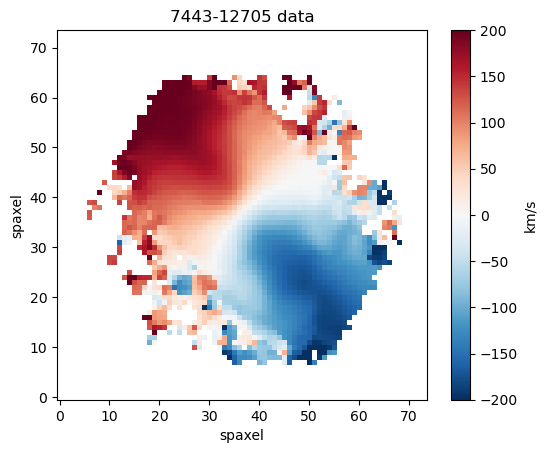

In [74]:
plt.imshow(maps['vmasked'], 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-200, 
           vmax=200)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar()
cbar.set_label('km/s')
plt.title('7443-12705 data')
plt.savefig("7443-12705_data")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-15.03924927 -14.73698214 -14.43471501 -14.13244787 -13.83018074
 -13.52791361 -13.22564648 -12.92337935 -12.62111221 -12.31884508
 -12.01657795 -11.71431082 -11.41204369 -11.10977655 -10.80750942
 -10.50524229 -10.20297516  -9.90070803  -9.59844089  -9.29617376
  -8.99390663  -8.6916395   -8.38937236  -8.08710523  -7.7848381
  -7.48257097  -7.18030384  -6.8780367   -6.57576957  -6.27350244
  -5.97123531  -5.66896818  -5.36670104  -5.06443391  -4.76216678
  -4.45989965  -4.15763252  -3.85536538  -3.55309825  -3.25083112
  -2.94856399  -2.64629686  -2.34402972  -2.04176259  -1.73949546
  -1.43722833  -1.1349612   -0.83269406  -0.53042693  -0.2281598
   0.07410733   0.37637446   0.6786416    0.98090873   1.28317586
   1.58544299   1.88771012   2.18997726   2.49224439   2.79451152
   3.09677865   3.39904579   3.70131292   4.00358005   4.30584718
   4.60811431   4.91038145   5.21264858   5.51491571   5.81718284
   6.11944997   6.42171711   6.72398424   7.02625137   7.3285185
   7.63078563

[-3.11887714e+01 -3.05888102e+01 -2.99888490e+01 -2.93888878e+01
 -2.87889266e+01 -2.81889654e+01 -2.75890042e+01 -2.69890430e+01
 -2.63890818e+01 -2.57891206e+01 -2.51891594e+01 -2.45891981e+01
 -2.39892369e+01 -2.33892757e+01 -2.27893145e+01 -2.21893533e+01
 -2.15893921e+01 -2.09894309e+01 -2.03894697e+01 -1.97895085e+01
 -1.91895473e+01 -1.85895861e+01 -1.79896248e+01 -1.73896636e+01
 -1.67897024e+01 -1.61897412e+01 -1.55897800e+01 -1.49898188e+01
 -1.43898576e+01 -1.37898964e+01 -1.31899352e+01 -1.25899740e+01
 -1.19900128e+01 -1.13900516e+01 -1.07900903e+01 -1.01901291e+01
 -9.59016793e+00 -8.99020672e+00 -8.39024551e+00 -7.79028430e+00
 -7.19032310e+00 -6.59036189e+00 -5.99040068e+00 -5.39043947e+00
 -4.79047826e+00 -4.19051705e+00 -3.59055585e+00 -2.99059464e+00
 -2.39063343e+00 -1.79067222e+00 -1.19071101e+00 -5.90749803e-01
  9.21140584e-03  6.09172614e-01  1.20913382e+00  1.80909503e+00
  2.40905624e+00  3.00901745e+00  3.60897866e+00  4.20893987e+00
  4.80890107e+00  5.40886

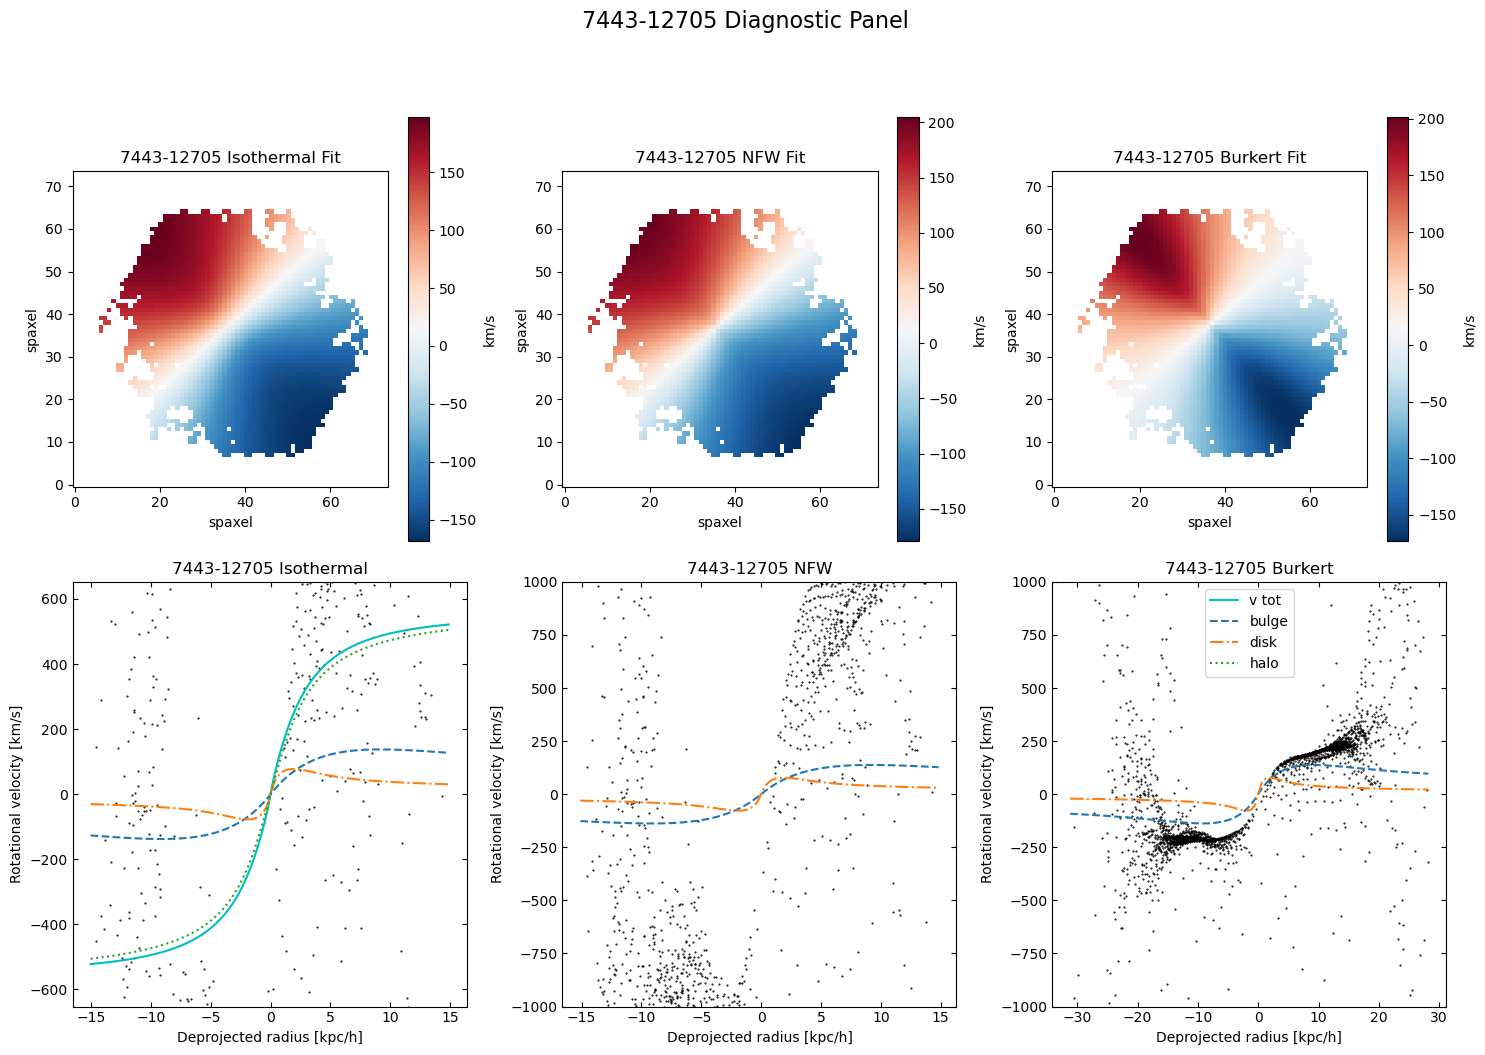

In [109]:
RC.plot_diagnostic_panel(gal_ID, shape, scale, iso_fit, NFW_fit, bur_fit, map_mask, maps['vmasked'],maps['ivarmasked'])


[-3.11887714e+01 -3.05888102e+01 -2.99888490e+01 -2.93888878e+01
 -2.87889266e+01 -2.81889654e+01 -2.75890042e+01 -2.69890430e+01
 -2.63890818e+01 -2.57891206e+01 -2.51891594e+01 -2.45891981e+01
 -2.39892369e+01 -2.33892757e+01 -2.27893145e+01 -2.21893533e+01
 -2.15893921e+01 -2.09894309e+01 -2.03894697e+01 -1.97895085e+01
 -1.91895473e+01 -1.85895861e+01 -1.79896248e+01 -1.73896636e+01
 -1.67897024e+01 -1.61897412e+01 -1.55897800e+01 -1.49898188e+01
 -1.43898576e+01 -1.37898964e+01 -1.31899352e+01 -1.25899740e+01
 -1.19900128e+01 -1.13900516e+01 -1.07900903e+01 -1.01901291e+01
 -9.59016793e+00 -8.99020672e+00 -8.39024551e+00 -7.79028430e+00
 -7.19032310e+00 -6.59036189e+00 -5.99040068e+00 -5.39043947e+00
 -4.79047826e+00 -4.19051705e+00 -3.59055585e+00 -2.99059464e+00
 -2.39063343e+00 -1.79067222e+00 -1.19071101e+00 -5.90749803e-01
  9.21140584e-03  6.09172614e-01  1.20913382e+00  1.80909503e+00
  2.40905624e+00  3.00901745e+00  3.60897866e+00  4.20893987e+00
  4.80890107e+00  5.40886

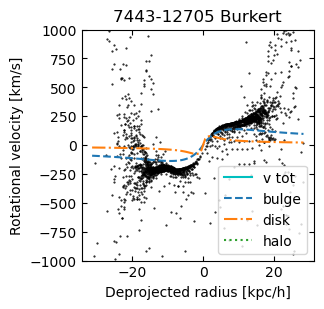

In [111]:

RC.plot_rot_curve(maps['vmasked'],maps['ivarmasked'],bur_fit,scale,gal_ID,'Burkert')

